We would like to simulate a network system in which packets travel through host_A to host_B through a router.

![]()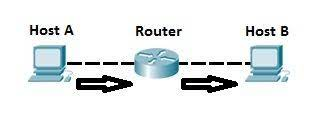

In [2]:
!pip install apscheduler

In [3]:
# import the required packages
import numpy as np
from time import time,sleep
from datetime import datetime, timedelta
from apscheduler.schedulers.background import BackgroundScheduler
import pandas as pd
import tzlocal
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [4]:
# Parameters
X= 3
Y= 0.8
T= 300 # Simulation time in seconds
PROCESSOR_NUM=3
SERVICE_POLICY='WRR' # 'FIFO', 'WRR', or 'NPPS'
LENGTH_LIMIT=5
PRIORITIES_PROBABILITY= [0.5,0.3,0.2] # 'Low', 'Medium', 'High'
PRIORITIES_WEIGHTS = [1,2,3]
PRIORITIES_NUM = len(PRIORITIES_PROBABILITY)
TIME_PRECISION=1

Useful links to understand [WRR](https://en.wikipedia.org/wiki/Weighted_round_robin) and [NPPS](https://www.educative.io/answers/what-is-a-non-preemptive-priority-scheduling-algorithm) service policies.

In [5]:
def time_rounder(t,up=False):
  if t==0:
    return t
  scale=10**TIME_PRECISION
  return np.round(int(t*scale)/scale + 10**(-TIME_PRECISION),TIME_PRECISION) if up else int(t*scale)/scale
def get_time(t0):
  return time_rounder(time()-t0)

In [6]:
class Packet():
  ID=0
  def __init__(self):
    self.id=Packet.ID
    Packet.ID+=1
    self.arrival_time=None
    self.queue_waiting_time=None
    self.service_start_time=None
    self.service_time=None
    self.total_waiting_time=None
    self.finish_time=None
    self.processor_id=None
    self.dropped=False
    self.priority=np.random.choice(np.arange(1,4),size=1,p=PRIORITIES_PROBABILITY).item()
    self.priority_weight=PRIORITIES_WEIGHTS[self.priority-1]
    self.dest_host=None

  def set_dropped(self):
    self.dropped=True
  def __repr__(self):
    return f'Packet{self.id}'

In [7]:
class Host():
  def __init__(self,name,T=T,log=True):
    self.packets=[]
    self.log=log
    self.name=name
    self.t0=time()
    self.T=T

  def reset_timer(self,t0=None):
    if t0: self.t0=t0
    else: self.t0=time()

  def make_packets(self,packet_rate,dest_host,max_packets=10):
    packets_interarrival_time=np.append(0,np.random.exponential(1/packet_rate,max_packets-1))
    last_arrival_time=0.0
    for interarrival_time in packets_interarrival_time:
      last_arrival_time+=time_rounder(interarrival_time,up=True)
      packet=Packet()
      packet.dest_host=dest_host
      self.router.scheduler.add_job(self.send_packet,'date',run_date=datetime.now()+timedelta(seconds=last_arrival_time),args=[packet])

  def set_router(self,router):
    self.router=router

  def send_packet(self,packet):
    self.packets.append(packet)
    self.print_log(f'Packet{packet.id} is sent from {self.name} to router at {get_time(self.t0)}')
    self.router.get_packet(packet)

  def get_packet(self,packet):
    self.print_log(f'Packet{packet.id} is received in {self.name} at {get_time(self.t0)}',color=32)
    self.packets.append(packet)

  def print_log(self,text,color=39):
    if self.log:
      print(f'\033[1;{color}m'+text)

  def get_event_table(self,only_finished_events=False):
    if only_finished_events:
      packets=list(filter(lambda x:x.finish_time or x.dropped,self.packets))
    else:
      packets=self.packets
    ids=[x.id for x in packets]
    priorities=[x.priority for x in packets]
    arrival_times=[x.arrival_time for x in packets]
    queue_waiting_times=[x.queue_waiting_time for x in packets]
    service_start_times=[x.service_start_time for x in packets]
    service_times=[x.service_time for x in packets]
    service_finish_times=[x.finish_time for x in packets]
    total_waiting_times=[x.total_waiting_time for x in packets]
    dropped=[x.dropped for x in packets]
    processors_service_start_times=[]
    processors_service_end_times=[]
    for i in np.arange(max(np.unique([x.processor_id if x.processor_id is not None else 0 for x in packets]))+1):
      starts=[]
      ends=[]
      for p in packets:
        if p.processor_id==i:
          starts.append(str(p.service_start_time))
          ends.append(str(p.finish_time))
        else:
          starts.append('-')
          ends.append('-')
      processors_service_start_times.append(starts)
      processors_service_end_times.append(ends)

    df=pd.DataFrame({'ID':ids,'Priority':priorities, 'Arrival_time':arrival_times,
                     'Queue_waiting_time':queue_waiting_times,'Service_time':service_times}).set_index('ID')

    for i in range(len(processors_service_start_times)):
      df[f'P{i}_start_time']=processors_service_start_times[i]
      df[f'P{i}_end_time']=processors_service_end_times[i]
    df['Total_waiting_time']=total_waiting_times
    df['Dropped']=dropped
    df=df.fillna('-').replace('None','-').sort_index()
    if not only_finished_events:
      for i in range(len(df)):
        if df.loc[ids[i],'Queue_waiting_time']=='-' and not df.loc[ids[i],'Dropped'] and self.packets[i].service_start_time==None:
          df.loc[ids[i],'Queue_waiting_time']=np.round(self.T-self.packets[i].arrival_time,TIME_PRECISION)
    return df

  def show_event_table(self,only_finished_events=False):
    df=self.get_event_table(only_finished_events)
    def highlight_df(s):
      if s['Dropped']=='True':
        return ['background-color: red; text-align: center;']*len(s)
      elif s['Queue_waiting_time']>'0.0':
        return ['background-color: yellow; text-align: center;']*len(s)
      else:
        return ['background-color: lime; text-align: center;']*len(s)
    colored_df=df.astype(str).style.apply(highlight_df, axis=1)
    display(HTML('<style>.output{font-weight: bold;font-size=60px}</style><div class="output">'+f'Status of {self.name}</div>'))
    display(HTML(colored_df.to_html()))


In [8]:
class Router():
  def __init__(self,scheduler,SERVICE_RATE,PROCESSOR_NUM,SERVICE_POLICY,LENGTH_LIMIT,PRIORITIES_NUM,log=True):
    self.scheduler=scheduler
    self.service_rate=SERVICE_RATE
    self.processor_num=PROCESSOR_NUM
    self.processors_task=[None for _ in range(PROCESSOR_NUM)]
    self.priority_queues=[[] for _ in range(PRIORITIES_NUM)]
    self.queue_cycler=PRIORITIES_NUM-1
    self.counter=0
    self.routers_queue=[]
    self.policy=SERVICE_POLICY
    self.queue_limit=LENGTH_LIMIT
    self.priorities_num=PRIORITIES_NUM
    self.log=log
    self.t0=time()

  def reset_timer(self,t0=None):
    if t0: self.t0=t0
    else: self.t0=time()

  def get_packet(self,packet:Packet):
    packet.arrival_time=get_time(self.t0)
    self.print_log(f'Packet{packet.id} entered router at {packet.arrival_time}')
    if not all(self.processors_task):
      for i in range(len(self.processors_task)):
        if not self.processors_task[i]:
          self.assign_packet(packet,i)
          break
    else:
      if self.policy=='FIFO':
        if len(self.routers_queue)<self.queue_limit:
          self.print_log(f'Packet{packet.id} is queued',33)
          self.routers_queue.append(packet)
        else:
          self.print_log(f'Packet{packet.id} is dropped',31)
          packet.dropped=True
          packet.finished=True
      elif self.policy=='NPPS':
        packet_queued=False
        if len(self.routers_queue)<self.queue_limit:
          for i in range(len(self.routers_queue)):
            if self.routers_queue[i].priority<packet.priority:
              self.routers_queue.insert(i,packet)
              packet_queued=True
              break
          if not packet_queued:
            self.routers_queue.append(packet)
          self.print_log(f'Packet{packet.id} is queued by priority',33)
        else:
          self.print_log(f'Packet{packet.id} is dropped',31)
          packet.dropped=True
          packet.finished=True
      elif self.policy=='WRR':
        if len(self.priority_queues[packet.priority-1])<self.queue_limit:
          self.priority_queues[packet.priority-1].append(packet)
          self.print_log(f'Packet{packet.id} is queued in priority{packet.priority} queue',33)
        else:
          self.print_log(f'Packet{packet.id} is dropped',31)
          packet.dropped=True
          packet.finished=True
      else:
        raise Exception(f'Service policy {self.policy} is not supported!')

  def assign_packet(self,packet,processor_id):
    packet.service_start_time=get_time(self.t0)
    packet.queue_waiting_time=np.round(packet.service_start_time-packet.arrival_time,TIME_PRECISION)
    packet.processor_id=processor_id
    self.print_log(f'Packet{packet.id} is assigned to processor{processor_id} at {packet.service_start_time}',35)
    self.processors_task[processor_id]=packet
    service_time=time_rounder(np.random.exponential(1/self.service_rate),up=True)
    packet.service_time=service_time
    self.scheduler.add_job(self.free_processor,'date',run_date=datetime.now()+timedelta(seconds=service_time),args=[processor_id])

  def free_processor(self,processor_id):
    packet=self.processors_task[processor_id]
    packet.finish_time=get_time(self.t0)
    packet.finished=True
    packet.total_waiting_time=np.round(packet.finish_time-packet.arrival_time,TIME_PRECISION)
    self.print_log(f'Packet{packet.id} is sent to {packet.dest_host.name} by processor{processor_id} at {packet.finish_time}',32)
    packet.dest_host.get_packet(packet)
    self.processors_task[processor_id]=None
    if self.policy in ['FIFO','NPPS']:
      if self.routers_queue:
        packet=self.routers_queue.pop(0)
        self.assign_packet(packet,processor_id)
    elif self.policy=='WRR':
      if self.priority_queues[self.queue_cycler]:
        packet=self.priority_queues[self.queue_cycler].pop(0)
        self.counter+=1
        if packet.priority_weight==self.counter:
          self.queue_cycler=(self.queue_cycler+1)%self.priorities_num
          self.counter=0
        self.assign_packet(packet,processor_id)
      else:
        first_cycler=self.queue_cycler
        self.queue_cycler=(self.queue_cycler+1)%self.priorities_num
        self.counter=0
        while first_cycler!=self.queue_cycler:
          if self.priority_queues[self.queue_cycler]:
            packet=self.priority_queues[self.queue_cycler].pop(0)
            self.counter+=1
            if packet.priority_weight==self.counter:
              self.queue_cycler=(self.queue_cycler+1)%self.priorities_num
              self.counter=0
            self.assign_packet(packet,processor_id)
            break
          else:
            self.queue_cycler=(self.queue_cycler+1)%self.priorities_num
    else:
      raise Exception(f'Service policy {self.policy} is not supported!')

  def print_log(self,text,color=39):
    if self.log:
      print(f'\033[1;{color}m'+text)

In [9]:
def run_simulation(X=X,Y=Y,PROCESSOR_NUM=PROCESSOR_NUM,SERVICE_POLICY=SERVICE_POLICY,PRIORITIES_NUM=PRIORITIES_NUM,
                   T=T, log_router=True,log_host=True,log_tqdm=False,description='Running simulation',max_packets=1000):
  scheduler = BackgroundScheduler(timezone=str(tzlocal.get_localzone()))
  scheduler.start()

  host_A=Host(name='Host_A',log=log_host,T=T)
  host_B=Host(name='Host_B',log=log_host,T=T)
  router=Router(scheduler,Y,PROCESSOR_NUM,SERVICE_POLICY,LENGTH_LIMIT,PRIORITIES_NUM,log=log_router)
  host_A.set_router(router)
  t0=time()
  host_A.reset_timer(t0)
  host_B.reset_timer(t0)
  router.reset_timer(t0)
  host_A.make_packets(packet_rate=X,dest_host=host_B,max_packets=max_packets)

  # This is here to simulate application activity (which keeps the main thread alive).
  try:
    if log_tqdm:
      pbar=tqdm(total=int(T),desc=description,disable=not log_tqdm)
      previous_t=0
      while True:
        t=time()-t0
        if t>=T:break
        if t>=previous_t+1:
          pbar.update(1)
          previous_t+=1
      pbar.update(1)
      pbar.close()
    else:
      while time()-t0 < T:
        pass
    scheduler.shutdown()
    Packet.ID=0
    del(scheduler)
  except KeyboardInterrupt:
    scheduler.shutdown()
    Packet.ID=0
    del(scheduler)
  return host_A,router,host_B

host_A,router,host_B = run_simulation(log_host=False,log_router=False,log_tqdm=True)

Running simulation:   0%|          | 0/300 [00:00<?, ?it/s]

In [10]:
host_A.show_event_table()

In [11]:
host_B.show_event_table()

,Priority,Arrival_time,Queue_waiting_time,Service_time,P0_start_time,P0_end_time,P1_start_time,P1_end_time,P2_start_time,P2_end_time,Total_waiting_time,Dropped
ID,,,,,,,,,,,,
0,3,0.0,0.0,1.1,0.0,1.1,-,-,-,-,1.1,False
1,1,0.3,0.0,0.7,-,-,0.3,1.0,-,-,0.7,False
2,2,0.5,0.0,0.8,-,-,-,-,0.5,1.3,0.8,False
3,1,0.8,0.2,1.4,-,-,1.0,2.4,-,-,1.6,False
4,1,0.9,0.2,0.6,1.1,1.7,-,-,-,-,0.8,False
5,1,1.0,0.3,0.8,-,-,-,-,1.3,2.1,1.1,False
6,3,2.5,0.0,1.8,2.5,4.3,-,-,-,-,1.8,False
7,3,2.8,0.0,0.8,-,-,2.8,3.6,-,-,0.8,False
8,2,3.0,0.0,0.1,-,-,-,-,3.0,3.1,0.1,False


In [12]:
event_table=host_A.get_event_table()

Average length queue with priority1: 2.942
Average length queue with priority2: 1.189
Average length queue with priority3: 0.480


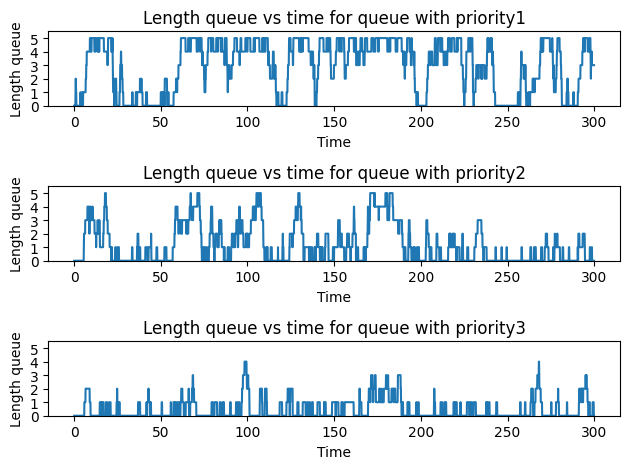

In [13]:
# Report average length of the queues
def report_average_length_queues(event_table,SERVICE_POLICY=SERVICE_POLICY,PROCESSOR_NUM=PROCESSOR_NUM,
                                 PRIORITIES_NUM=PRIORITIES_NUM,LENGTH_LIMIT=LENGTH_LIMIT,T=T, plot=True):
  if SERVICE_POLICY in ['FIFO','NPPS']:
    average_length_queue=0
    packet_arrival_times=event_table.loc[~event_table['Dropped'],'Arrival_time']
    packet_start_times=[]
    for i in packet_arrival_times.index:
      start_time_exists=False
      for j in range(PROCESSOR_NUM):
        t_start=event_table.loc[i][f'P{j}_start_time']
        if t_start!='-':
          start_time_exists=True
          packet_start_times.append(float(t_start))
          break
      if not start_time_exists:
        packet_start_times.append(T+0.1)

    time_range=np.arange(0,T,10**(-TIME_PRECISION))
    length_queue=[]
    packet_arrival_times=packet_arrival_times.tolist()
    for t in time_range:
      count_packets_in_queue=0
      for i in range(len(packet_arrival_times)):
        if packet_arrival_times[i]<= t < packet_start_times[i]:
          count_packets_in_queue+=1
      length_queue.append(count_packets_in_queue)
    print(f'Average length queue: {sum(length_queue)*10**(-TIME_PRECISION)/T:.3f}')
    if plot:
      plt.title('Length queue vs time')
      plt.xlabel('Time')
      plt.ylabel('Length queue')
      plt.plot(time_range,length_queue)
  elif SERVICE_POLICY=='WRR':
    average_length_queue=0
    for priority in range(PRIORITIES_NUM):
      packet_arrival_times=event_table.loc[(~event_table['Dropped']) & (event_table['Priority']==(priority+1)),'Arrival_time']
      packet_start_times=[]
      for i in packet_arrival_times.index:
        start_time_exists=False
        for j in range(PROCESSOR_NUM):
          t_start=event_table.loc[i][f'P{j}_start_time']
          if t_start!='-':
            start_time_exists=True
            packet_start_times.append(float(t_start))
            break
        if not start_time_exists:
          packet_start_times.append(T+0.1)

      time_range=np.arange(0,T,10**(-TIME_PRECISION))
      length_queue=[]
      packet_arrival_times=packet_arrival_times.tolist()
      for t in time_range:
        count_packets_in_queue=0
        for i in range(len(packet_arrival_times)):
          if packet_arrival_times[i]<= t < packet_start_times[i]:
            count_packets_in_queue+=1
        length_queue.append(count_packets_in_queue)
      print(f'Average length queue with priority{priority+1}: {sum(length_queue)*10**(-TIME_PRECISION)/T:.3f}')
      if plot:
        ax=plt.subplot(311+priority)
        ax.set_ylim(bottom=0,top=LENGTH_LIMIT+0.5)
        ax.set_yticks(np.arange(0,LENGTH_LIMIT+1))
        ax.set_title(f'Length queue vs time for queue with priority{priority+1}')
        ax.set_xlabel('Time')
        ax.set_ylabel('Length queue')
        ax.plot(time_range,length_queue)
    if plot:
      plt.tight_layout()
      plt.show()
report_average_length_queues(event_table)

In [14]:
# Report average queue waiting time
def report_average_queue_waiting_time(event_table):
  print(f'Average queue waiting time: {event_table.loc[~event_table["Dropped"],"Queue_waiting_time"].mean():.3f}')

report_average_queue_waiting_time(event_table)

Average queue waiting time: 2.206


In [15]:
# Report average each queue waiting time
def report_average_each_queue_waiting_time(event_table):
  if SERVICE_POLICY=='WRR':
    for priority in range(PRIORITIES_NUM):
      print(f'Average queue waiting time for queue with priority{priority+1}:',
       f'{event_table.loc[(event_table["Priority"]==(1+priority)) & (~event_table["Dropped"]),"Queue_waiting_time"].mean():.3f}')
  else:
    report_average_queue_waiting_time(event_table)

report_average_each_queue_waiting_time(event_table)

Average queue waiting time for queue with priority1: 3.421
Average queue waiting time for queue with priority2: 1.614
Average queue waiting time for queue with priority3: 0.973


In [16]:
# Report processors utilization
def report_processors_utilization(event_table):
  for processor in range(PROCESSOR_NUM):
    processor_times=event_table.loc[event_table[f'P{processor}_start_time']!='-',[f'P{processor}_start_time',f'P{processor}_end_time']].replace('-',T).astype(float)
    utilization=sum(processor_times[f'P{processor}_end_time']-processor_times[f'P{processor}_start_time'])/T
    print(f'Processor{processor+1} utilization: {utilization:.3f}')

report_processors_utilization(event_table)

Processor1 utilization: 0.956
Processor2 utilization: 0.949
Processor3 utilization: 0.938


In [17]:
# Report count dropped packets
def report_count_dropped_packets(event_table):
  print(f'Count of dropped packets: {len(event_table.loc[event_table["Dropped"]])}')
  print('-'*35)
  print(f'Count of total packets: {len(event_table)}')

report_count_dropped_packets(event_table)

Count of dropped packets: 112
-----------------------------------
Count of total packets: 739


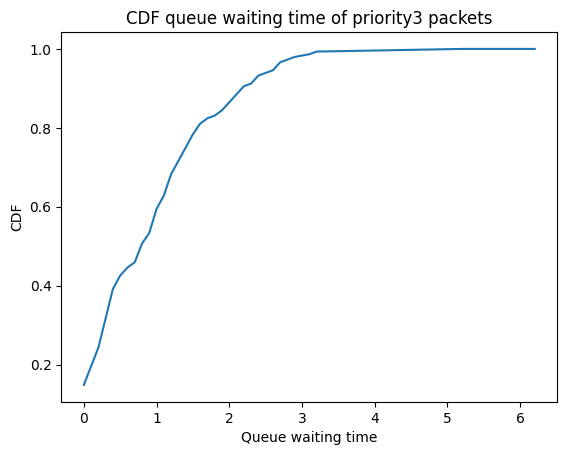

In [18]:
# Draw CDF queue waiting time of high priority packets
def draw_CDF_queue_waiting_time(event_table,priority=PRIORITIES_NUM):
  queue_waiting_times=sorted(event_table.loc[(event_table["Priority"]==(priority)) & (~event_table["Dropped"]),"Queue_waiting_time"].tolist())
  cdf=[np.mean(np.array(queue_waiting_times)<=x) for x in queue_waiting_times]
  plt.title(f'CDF queue waiting time of priority{priority} packets')
  plt.xlabel('Queue waiting time')
  plt.ylabel('CDF')
  plt.plot(queue_waiting_times+[queue_waiting_times[-1]+1],cdf+[1])

draw_CDF_queue_waiting_time(event_table)

In [19]:
def get_count_received_packets(host_B):
  return len(host_B.packets)
def get_count_dropped_packets(event_table):
  return len(event_table.loc[event_table["Dropped"]])

def run_different_service_policies():
  for policy in ['FIFO','NPPS','WRR']:
    host_A,router,host_B=run_simulation(SERVICE_POLICY=policy,log_router=False,
                                        log_host=False,log_tqdm=True,description=f'Running simulation with {policy} policy')
    event_table=host_A.get_event_table()
    count_received_packets=get_count_received_packets(host_B)
    count_dropped_packets=get_count_dropped_packets(event_table)
    count_total_packets=len(event_table)
    count_pending_packets=count_total_packets-count_received_packets-count_dropped_packets
    print('Count of received packets:', count_received_packets)
    print('Count of dropped packets:',count_dropped_packets)
    print('Count of pending packets:',count_pending_packets)
    print('+')
    print('-'*35)
    print(f'Count of total packets: {count_total_packets}\n')
    print(f'-----> Ratio of received packets to total: {count_received_packets/count_total_packets:.3f}')
    print(f'-----> Ratio of dropped packets to total: {count_dropped_packets/count_total_packets:.3f}')

    print('************************************************')

run_different_service_policies()

Running simulation with FIFO policy:   0%|          | 0/300 [00:00<?, ?it/s]

Count of received packets: 644
Count of dropped packets: 90
Count of pending packets: 3
+
-----------------------------------
Count of total packets: 737

-----> Ratio of received packets to total: 0.874
-----> Ratio of dropped packets to total: 0.122
************************************************


Running simulation with NPPS policy:   0%|          | 0/300 [00:00<?, ?it/s]

Count of received packets: 678
Count of dropped packets: 121
Count of pending packets: 3
+
-----------------------------------
Count of total packets: 802

-----> Ratio of received packets to total: 0.845
-----> Ratio of dropped packets to total: 0.151
************************************************


Running simulation with WRR policy:   0%|          | 0/300 [00:00<?, ?it/s]

Count of received packets: 652
Count of dropped packets: 98
Count of pending packets: 6
+
-----------------------------------
Count of total packets: 756

-----> Ratio of received packets to total: 0.862
-----> Ratio of dropped packets to total: 0.130
************************************************


In [22]:
def get_processors_average_utilization(event_table,processor_num):
  utilizations=[]
  for processor in range(processor_num):
    processor_times=event_table.loc[event_table[f'P{processor}_start_time']!='-',[f'P{processor}_start_time',f'P{processor}_end_time']].replace('-',T).astype(float)
    utilization=sum(processor_times[f'P{processor}_end_time']-processor_times[f'P{processor}_start_time'])/T
    utilizations.append(utilization)
  return np.round(np.mean(utilizations),3)

def evaluate_systems_utilization(Xs:list,Ys:list,processor_nums:list,policy):
  conditions=[]
  for x in Xs:
    for y in Ys:
      for processor_num in processor_nums:
        host_A,router,host_B=run_simulation(SERVICE_POLICY=policy,log_router=False,
                                        log_host=False,log_tqdm=True,T=60,X=x,Y=y,PROCESSOR_NUM=processor_num,
                                        description=f'Running simulation with {policy} policy and X={x}, Y={y}, processor_num={processor_num}')
        event_table=host_A.get_event_table()
        system_utilization=get_processors_average_utilization(event_table,processor_num)
        conditions.append([x,y,processor_num,system_utilization])
        print(f'System\'s utilization: {system_utilization}')
  return conditions

Xs=[2,3,4]
Ys=[0.7,0.8,0.9]
processor_nums=[2,3,4]

In [23]:
FIFO_evaluation=evaluate_systems_utilization(Xs,Ys,processor_nums,'FIFO')

Running simulation with FIFO policy and X=2, Y=0.7, processor_num=2:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.996


Running simulation with FIFO policy and X=2, Y=0.7, processor_num=3:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.941


Running simulation with FIFO policy and X=2, Y=0.7, processor_num=4:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.518


Running simulation with FIFO policy and X=2, Y=0.8, processor_num=2:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.988


Running simulation with FIFO policy and X=2, Y=0.8, processor_num=3:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.958


Running simulation with FIFO policy and X=2, Y=0.8, processor_num=4:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.533


Running simulation with FIFO policy and X=2, Y=0.9, processor_num=2:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.983


Running simulation with FIFO policy and X=2, Y=0.9, processor_num=3:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.667


Running simulation with FIFO policy and X=2, Y=0.9, processor_num=4:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.922


Running simulation with FIFO policy and X=3, Y=0.7, processor_num=2:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.999


Running simulation with FIFO policy and X=3, Y=0.7, processor_num=3:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.988


Running simulation with FIFO policy and X=3, Y=0.7, processor_num=4:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.37


Running simulation with FIFO policy and X=3, Y=0.8, processor_num=2:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.992


Running simulation with FIFO policy and X=3, Y=0.8, processor_num=3:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.985


Running simulation with FIFO policy and X=3, Y=0.8, processor_num=4:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.744


Running simulation with FIFO policy and X=3, Y=0.9, processor_num=2:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.999


Running simulation with FIFO policy and X=3, Y=0.9, processor_num=3:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.977


Running simulation with FIFO policy and X=3, Y=0.9, processor_num=4:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.959


Running simulation with FIFO policy and X=4, Y=0.7, processor_num=2:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 1.0


Running simulation with FIFO policy and X=4, Y=0.7, processor_num=3:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.993


Running simulation with FIFO policy and X=4, Y=0.7, processor_num=4:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.992


Running simulation with FIFO policy and X=4, Y=0.8, processor_num=2:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.998


Running simulation with FIFO policy and X=4, Y=0.8, processor_num=3:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.991


Running simulation with FIFO policy and X=4, Y=0.8, processor_num=4:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.991


Running simulation with FIFO policy and X=4, Y=0.9, processor_num=2:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 1.0


Running simulation with FIFO policy and X=4, Y=0.9, processor_num=3:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.989


Running simulation with FIFO policy and X=4, Y=0.9, processor_num=4:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.972


In [29]:
pd.DataFrame(FIFO_evaluation,columns=['X','Y','Processor_num','System_utilization'])

,X,Y,Processor_num,System_utilization
0,2,0.7,2,0.996
1,2,0.7,3,0.941
2,2,0.7,4,0.518
3,2,0.8,2,0.988
4,2,0.8,3,0.958
5,2,0.8,4,0.533
6,2,0.9,2,0.983
7,2,0.9,3,0.667
8,2,0.9,4,0.922
9,3,0.7,2,0.999


In [30]:
NPPS_evaluation=evaluate_systems_utilization(Xs,Ys,processor_nums,'NPPS')

Running simulation with NPPS policy and X=2, Y=0.7, processor_num=2:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.971


Running simulation with NPPS policy and X=2, Y=0.7, processor_num=3:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.951


Running simulation with NPPS policy and X=2, Y=0.7, processor_num=4:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.931


Running simulation with NPPS policy and X=2, Y=0.8, processor_num=2:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.991


Running simulation with NPPS policy and X=2, Y=0.8, processor_num=3:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.951


Running simulation with NPPS policy and X=2, Y=0.8, processor_num=4:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.73


Running simulation with NPPS policy and X=2, Y=0.9, processor_num=2:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.154


Running simulation with NPPS policy and X=2, Y=0.9, processor_num=3:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.395


Running simulation with NPPS policy and X=2, Y=0.9, processor_num=4:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.486


Running simulation with NPPS policy and X=3, Y=0.7, processor_num=2:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.993


Running simulation with NPPS policy and X=3, Y=0.7, processor_num=3:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.991


Running simulation with NPPS policy and X=3, Y=0.7, processor_num=4:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.976


Running simulation with NPPS policy and X=3, Y=0.8, processor_num=2:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 1.0


Running simulation with NPPS policy and X=3, Y=0.8, processor_num=3:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.964


Running simulation with NPPS policy and X=3, Y=0.8, processor_num=4:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.548


Running simulation with NPPS policy and X=3, Y=0.9, processor_num=2:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.599


Running simulation with NPPS policy and X=3, Y=0.9, processor_num=3:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.975


Running simulation with NPPS policy and X=3, Y=0.9, processor_num=4:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.748


Running simulation with NPPS policy and X=4, Y=0.7, processor_num=2:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.999


Running simulation with NPPS policy and X=4, Y=0.7, processor_num=3:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.999


Running simulation with NPPS policy and X=4, Y=0.7, processor_num=4:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.992


Running simulation with NPPS policy and X=4, Y=0.8, processor_num=2:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 1.0


Running simulation with NPPS policy and X=4, Y=0.8, processor_num=3:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.991


Running simulation with NPPS policy and X=4, Y=0.8, processor_num=4:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.977


Running simulation with NPPS policy and X=4, Y=0.9, processor_num=2:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.999


Running simulation with NPPS policy and X=4, Y=0.9, processor_num=3:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.999


Running simulation with NPPS policy and X=4, Y=0.9, processor_num=4:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.964


In [31]:
pd.DataFrame(NPPS_evaluation,columns=['X','Y','Processor_num','System_utilization'])

,X,Y,Processor_num,System_utilization
0,2,0.7,2,0.971
1,2,0.7,3,0.951
2,2,0.7,4,0.931
3,2,0.8,2,0.991
4,2,0.8,3,0.951
5,2,0.8,4,0.730
6,2,0.9,2,0.154
7,2,0.9,3,0.395
8,2,0.9,4,0.486
9,3,0.7,2,0.993


In [32]:
WRR_evaluation=evaluate_systems_utilization(Xs,Ys,processor_nums,'WRR')

Running simulation with WRR policy and X=2, Y=0.7, processor_num=2:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.977


Running simulation with WRR policy and X=2, Y=0.7, processor_num=3:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.685


Running simulation with WRR policy and X=2, Y=0.7, processor_num=4:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.54


Running simulation with WRR policy and X=2, Y=0.8, processor_num=2:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.994


Running simulation with WRR policy and X=2, Y=0.8, processor_num=3:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.701


Running simulation with WRR policy and X=2, Y=0.8, processor_num=4:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.509


Running simulation with WRR policy and X=2, Y=0.9, processor_num=2:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.972


Running simulation with WRR policy and X=2, Y=0.9, processor_num=3:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.665


Running simulation with WRR policy and X=2, Y=0.9, processor_num=4:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.301


Running simulation with WRR policy and X=3, Y=0.7, processor_num=2:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.997


Running simulation with WRR policy and X=3, Y=0.7, processor_num=3:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.981


Running simulation with WRR policy and X=3, Y=0.7, processor_num=4:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.994


Running simulation with WRR policy and X=3, Y=0.8, processor_num=2:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.999


Running simulation with WRR policy and X=3, Y=0.8, processor_num=3:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.98


Running simulation with WRR policy and X=3, Y=0.8, processor_num=4:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.365


Running simulation with WRR policy and X=3, Y=0.9, processor_num=2:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.996


Running simulation with WRR policy and X=3, Y=0.9, processor_num=3:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.987


Running simulation with WRR policy and X=3, Y=0.9, processor_num=4:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.327


Running simulation with WRR policy and X=4, Y=0.7, processor_num=2:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.999


Running simulation with WRR policy and X=4, Y=0.7, processor_num=3:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 1.0


Running simulation with WRR policy and X=4, Y=0.7, processor_num=4:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.986


Running simulation with WRR policy and X=4, Y=0.8, processor_num=2:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 1.0


Running simulation with WRR policy and X=4, Y=0.8, processor_num=3:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.999


Running simulation with WRR policy and X=4, Y=0.8, processor_num=4:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.991


Running simulation with WRR policy and X=4, Y=0.9, processor_num=2:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 1.0


Running simulation with WRR policy and X=4, Y=0.9, processor_num=3:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.999


Running simulation with WRR policy and X=4, Y=0.9, processor_num=4:   0%|          | 0/60 [00:00<?, ?it/s]

System's utilization: 0.966


In [33]:
pd.DataFrame(WRR_evaluation,columns=['X','Y','Processor_num','System_utilization'])

,X,Y,Processor_num,System_utilization
0,2,0.7,2,0.977
1,2,0.7,3,0.685
2,2,0.7,4,0.540
3,2,0.8,2,0.994
4,2,0.8,3,0.701
5,2,0.8,4,0.509
6,2,0.9,2,0.972
7,2,0.9,3,0.665
8,2,0.9,4,0.301
9,3,0.7,2,0.997
